In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense

2024-08-01 15:58:00.655829: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-01 15:58:00.685266: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Classification 기반의 환자예측

In [14]:
path='/home/hwchoi/001.project/data/T_PATIENTS_DAILY_WHOLE_0731.csv'
df=pd.read_csv(path)
df.head(2)

,sido,create_date,sido_cd,weekend_yn,grid_x,grid_y,sat_x,sat_y,min_ta,max_ta,...,ta_mean_six_am2,ta_min_six_pm1,ta_max_six_pm1,ta_mean_six_pm1,ta_min_six_pm2,ta_max_six_pm2,ta_mean_six_pm2,patientsCnt,instDate,updtDate
0,경기도,2014-05-01,31,0,60,120,NaN,NaN,9.6,24.2,...,15,21,24,22,14,21,17,0,2024-07-31,2024-07-31
1,충청북도,2014-05-01,33,0,69,107,NaN,NaN,10.5,23.7,...,15,21,23,22,15,22,18,0,2024-07-31,2024-07-31


#### Create_date 정렬(Sorting) / All feature

In [15]:
# create_date에 대한 sorting 적용
# 날짜 형식으로 변환 및 필요한 컬럼 선택
df['patientsCD'] = np.where(df['patientsCnt'] == 0, 0, 1)
df['create_date'] = pd.to_datetime(df['create_date'])
df.sort_values(by='create_date', inplace=True)
# 결측치 채우기
df = df.fillna(0)

In [16]:
features=['weekend_yn', 'sido_cd', 'min_ta', 'max_ta', 'mean_ta', 'gap_ta', 'min_tafeel', 'max_tafeel', 'mean_tafeel', 'gap_tafeel', 'min_hm', 'max_hm',
       'mean_hm', 'gap_hm', 'min_wbtemp', 'max_wbtemp', 'mean_wbtemp', 'gap_wbtemp', 'min_ws', 'max_ws', 'mean_ws', 'tropical_3days',
       'heatwave_temp', 'heatalert_temp', 'ta_min_3days', 'ta_max_3days', 'gap_ta_minmax', 'popular_man', 'popular_woman', 'agriculture_man',
       'agriculture_woman', 'ta_min_am', 'ta_max_am', 'ta_mean_am', 'ta_min_pm', 'ta_max_pm', 'ta_mean_pm', 'ta_min_six_am1',
       'ta_max_six_am1', 'ta_mean_six_am1', 'ta_min_six_am2', 'ta_max_six_am2', 'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1', 'ta_mean_six_pm1', 'ta_min_six_pm2', 'ta_max_six_pm2', 'ta_mean_six_pm2']
target='patientsCD'

In [17]:
# 데이터 스케일링
scaler = StandardScaler()
df[features]=scaler.fit_transform(df[features])

# 입력 시퀀스 준비 함수
def create_sequences(data, features, target, sequence_length):
    X = []
    y = []
    dates = []
    for i in range(len(data) - sequence_length):
        X.append(data[features].iloc[i:i+sequence_length].values)
        y.append(data[target].iloc[i+sequence_length])
        dates.append(data['create_date'].iloc[i+sequence_length])
    return np.array(X), np.array(y), np.array(dates)

In [18]:
sequence_length = 15
X, y, dates = create_sequences(df, features, target, sequence_length)

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(X, y, dates, test_size=0.2, random_state=11, shuffle=False)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (20796, 15, 49)
X_test shape: (5199, 15, 49)
y_train shape: (20796,)
y_test shape: (5199,)


### 1-1. RNN Modeling

In [19]:
# RNN 모델 생성 및 학습
rnn_model = Sequential()
rnn_model.add(SimpleRNN(50, activation='relu', input_shape=(sequence_length, len(features))))
rnn_model.add(Dense(1, activation='sigmoid'))  # 이진 분류를 위한 sigmoid 활성화 함수
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # 이진 분류를 위한 손실 함수와 평가 지표
# 모델 학습
rnn_history = rnn_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# 모델 평가
rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test, y_test)
print('RNN Test Loss:', rnn_loss)
print('RNN Test Accuracy:', rnn_accuracy)

# 예측값 생성
rnn_predictions = (rnn_model.predict(X_test) > 0.5).astype(int)

# 평가지표
rnn_accuracy = accuracy_score(y_test, rnn_predictions)
rnn_precision = precision_score(y_test, rnn_predictions)
rnn_recall = recall_score(y_test, rnn_predictions)
rnn_f1 = f1_score(y_test, rnn_predictions)

print('RNN Test Accuracy:', rnn_accuracy)
print('RNN Test Precision:', rnn_precision)
print('RNN Test Recall:', rnn_recall)
print('RNN Test F1 Score:', rnn_f1)

Epoch 1/50


/home/hwchoi/anaconda3/envs/kdca/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8451 - loss: 0.3699 - val_accuracy: 0.8113 - val_loss: 0.4216
Epoch 2/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8535 - loss: 0.3487 - val_accuracy: 0.8059 - val_loss: 0.4249
Epoch 3/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8610 - loss: 0.3217 - val_accuracy: 0.8128 - val_loss: 0.4156
Epoch 4/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8624 - loss: 0.3238 - val_accuracy: 0.8073 - val_loss: 0.4157
Epoch 5/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8597 - loss: 0.3241 - val_accuracy: 0.8136 - val_loss: 0.4141
Epoch 6/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8684 - loss: 0.3096 - val_accuracy: 0.8055 - val_loss: 0.4198
Epoch 7/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8671 - loss: 0.3066 - val_accuracy: 0.8067 - val_loss: 0.4248
Epoch 8/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8665 - loss: 0.3066 - val_accuracy: 0.8109 - val_

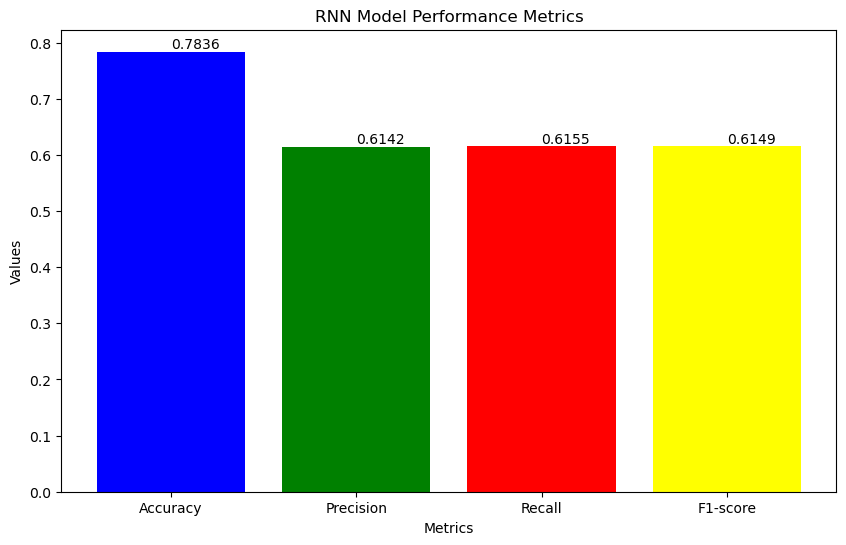

In [21]:
# 성능 평가 지표를 리스트로 정리
model = ['RNN', 'RNN', 'RNN', 'RNN']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [rnn_accuracy, rnn_precision, rnn_recall, rnn_f1]

# 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'red', 'yellow'])

# 막대 그래프에 값 표시
for bar, value in zip(bars, values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(value, 4), va='bottom')  # 중앙 정렬 및 값 표시

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('RNN Model Performance Metrics')
plt.show()

### 1-2. LSTM Model

In [23]:
### LSTM 모델 ###
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(sequence_length, len(features))))
lstm_model.add(Dense(1, activation='sigmoid'))  # 이진 분류를 위한 sigmoid 활성화 함수
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # 이진 분류를 위한 손실 함수와 평가 지표

# 모델 학습
lstm_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# 모델 평가
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test, y_test)
lstm_predictions = (lstm_model.predict(X_test) > 0.5).astype(int)

# 평가지표
lstm_accuracy = accuracy_score(y_test, lstm_predictions)
lstm_precision = precision_score(y_test, lstm_predictions)
lstm_recall = recall_score(y_test, lstm_predictions)
lstm_f1 = f1_score(y_test, lstm_predictions)

print('LSTM Test Accuracy:', lstm_accuracy)
print('LSTM Test Precision:', lstm_precision)
print('LSTM Test Recall:', lstm_recall)
print('LSTM Test F1 Score:', lstm_f1)

Epoch 1/50


/home/hwchoi/anaconda3/envs/kdca/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8369 - loss: 0.3763 - val_accuracy: 0.8023 - val_loss: 0.4218
Epoch 2/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8597 - loss: 0.3302 - val_accuracy: 0.8044 - val_loss: 0.4146
Epoch 3/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8583 - loss: 0.3304 - val_accuracy: 0.8057 - val_loss: 0.4131
Epoch 4/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8641 - loss: 0.3196 - val_accuracy: 0.7925 - val_loss: 0.4443
Epoch 5/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8607 - loss: 0.3221 - val_accuracy: 0.7967 - val_loss: 0.4207
Epoch 6/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8628 - loss: 0.3167 - val_accuracy: 0.8144 - val_loss: 0.4105
Epoch 7/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8708 - loss: 0.2979 - val_accuracy: 0.8121 - val_loss: 0.4142
Epoch 8/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8729 - loss: 0.2982 - val_accuracy: 0.7978 - val_

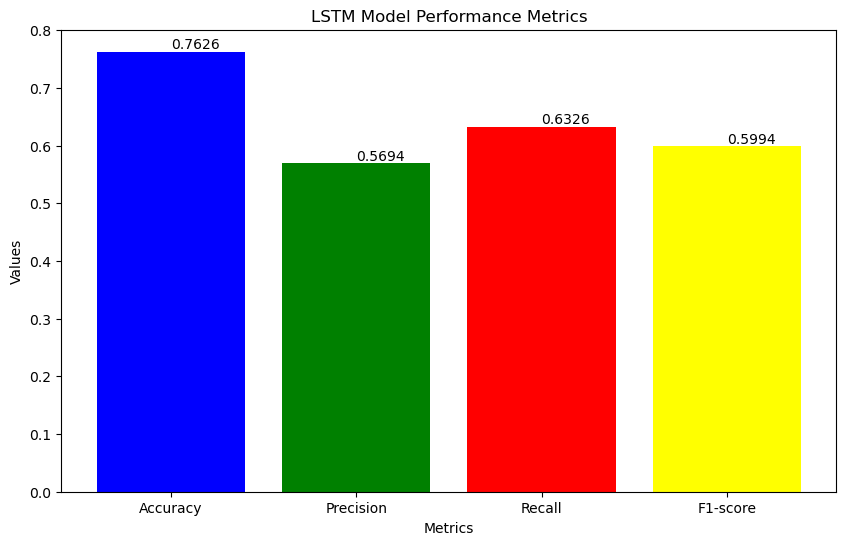

In [25]:
# 성능 평가 지표를 리스트로 정리
model = ['LSTM', 'LSTM', 'LSTM', 'LSTM']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [lstm_accuracy, lstm_precision, lstm_recall, lstm_f1]

# 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'red', 'yellow'])

# 막대 그래프에 값 표시
for bar, value in zip(bars, values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(value, 4), va='bottom')  # 중앙 정렬 및 값 표시

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('LSTM Model Performance Metrics')
plt.show()

### 1-3. RandomForest Model

In [29]:
# randomforest, xgboost는 flatten 과정 필요
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

rf_model = RandomForestClassifier(n_estimators=100, random_state=11)
rf_model.fit(X_train_flat, y_train)

# 모델 평가
rf_predictions = rf_model.predict(X_test_flat)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)
rf_f1 = f1_score(y_test, rf_predictions)

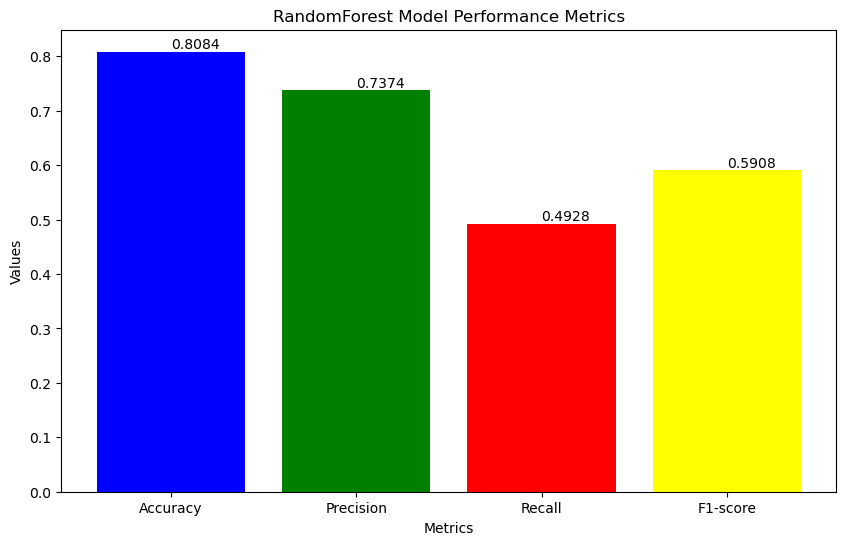

In [30]:
# 성능 평가 지표를 리스트로 정리
model = ['RandomForest', 'RandomForest', 'RandomForest', 'RandomForest']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [rf_accuracy, rf_precision, rf_recall, rf_f1]

# 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'red', 'yellow'])

# 막대 그래프에 값 표시
for bar, value in zip(bars, values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(value, 4), va='bottom')  # 중앙 정렬 및 값 표시

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('RandomForest Model Performance Metrics')
plt.show()

### 1-4. XGBoost Model

In [31]:
### XGBoost 모델 ###
xgb_model = XGBClassifier(n_estimators=100, random_state=11)
xgb_model.fit(X_train_flat, y_train)

# 모델 평가
xgb_predictions = xgb_model.predict(X_test_flat)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_precision = precision_score(y_test, xgb_predictions)
xgb_recall = recall_score(y_test, xgb_predictions)
xgb_f1 = f1_score(y_test, xgb_predictions)

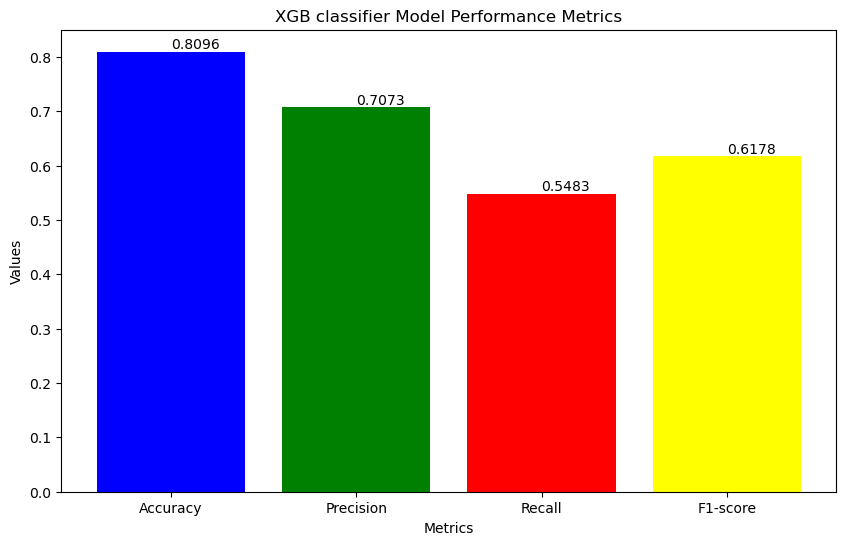

In [32]:
# 성능 평가 지표를 리스트로 정리
model = ['XGBoost', 'XGBoost', 'XGBoost', 'XGBoost']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [xgb_accuracy, xgb_precision, xgb_recall, xgb_f1]

# 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'red', 'yellow'])

# 막대 그래프에 값 표시
for bar, value in zip(bars, values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(value, 4), va='bottom')  # 중앙 정렬 및 값 표시

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('XGB classifier Model Performance Metrics')
plt.show()

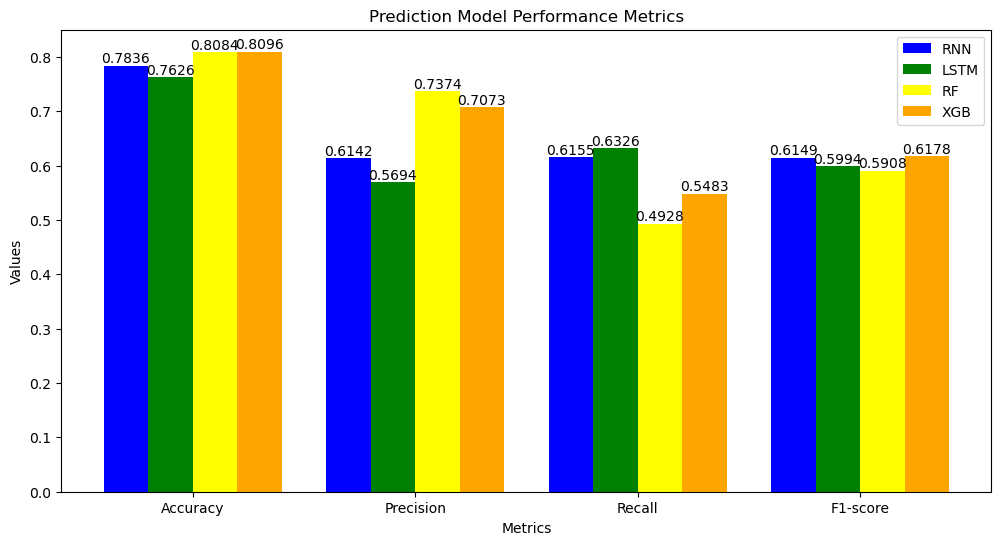

In [33]:
# 성능 평가 지표를 리스트로 정리
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
rnn_values = [rnn_accuracy, rnn_precision, rnn_recall, rnn_f1]
lstm_values = [lstm_accuracy, lstm_precision, lstm_recall, lstm_f1]
rf_values = [rf_accuracy, rf_precision, rf_recall, rf_f1]
xgb_values = [xgb_accuracy, xgb_precision, xgb_recall, xgb_f1]

# 시각화
x = np.arange(len(metrics))  # 각 지표에 대한 레이블 위치
width = 0.2  # 막대 너비

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - 1.5 * width, rnn_values, width, label='RNN', color='blue')
bars2 = ax.bar(x - 0.5 * width, lstm_values, width, label='LSTM', color='green')
bars3 = ax.bar(x + 0.5 * width, rf_values, width, label='RF', color='yellow')
bars4 = ax.bar(x + 1.5 * width, xgb_values, width, label='XGB', color='orange')

# 막대 그래프에 값 표시
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), va='bottom', ha='center')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
add_labels(bars4)

# 레이블 및 제목 설정
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Prediction Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# plt.savefig('Prediction Model Performance Metrics.png')
plt.show()

RNN Test Accuracy: 0.7836
RNN Test Precision: 0.6142
RNN Test Recall: 0.6155
RNN Test F1 Score: 0.6149
LSTM Test Accuracy: 0.7626
LSTM Test Precision: 0.5694
LSTM Test Recall: 0.6326
LSTM Test F1 Score: 0.5994
RandomForest Test Accuracy: 0.8084
RandomForest Test Precision: 0.7374
RandomForest Test Recall: 0.4928
RandomForest Test F1 Score: 0.5908
XGBoost Test Accuracy: 0.8096
XGBoost Test Precision: 0.7073
XGBoost Test Recall: 0.5483
XGBoost Test F1 Score: 0.6178


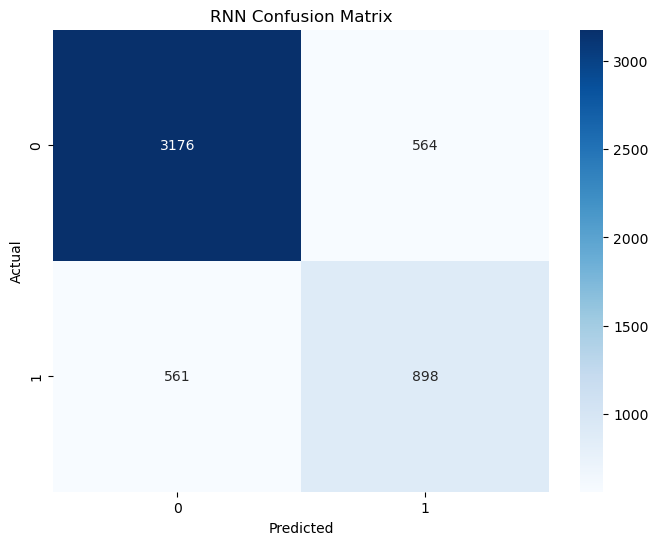

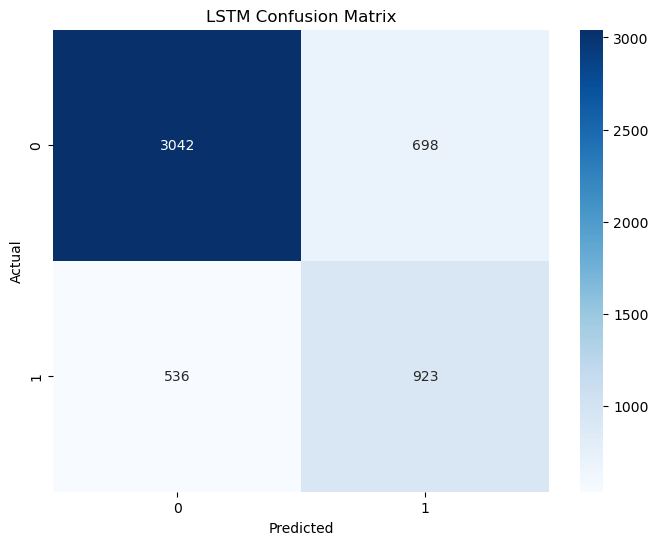

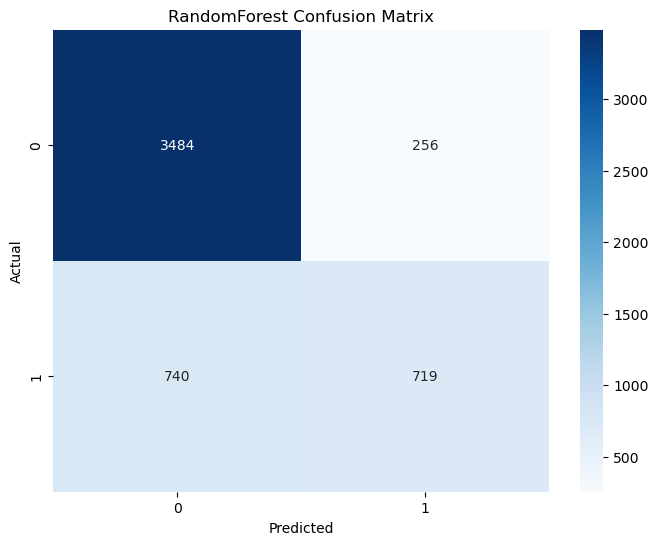

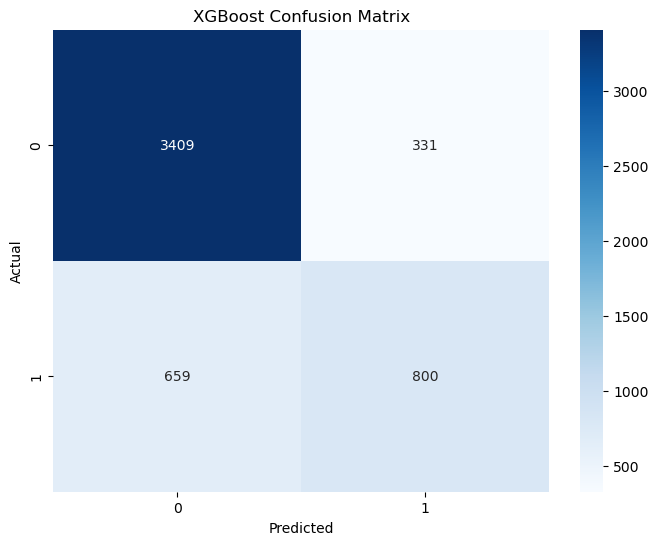

In [37]:
# 결과 출력
def print_metrics(model_name, accuracy, precision, recall, f1):
    print(f'{model_name} Test Accuracy: {accuracy:.4f}')
    print(f'{model_name} Test Precision: {precision:.4f}')
    print(f'{model_name} Test Recall: {recall:.4f}')
    print(f'{model_name} Test F1 Score: {f1:.4f}')

print_metrics('RNN', rnn_accuracy, rnn_precision, rnn_recall, rnn_f1)
print_metrics('LSTM', lstm_accuracy, lstm_precision, lstm_recall, lstm_f1)
print_metrics('RandomForest', rf_accuracy, rf_precision, rf_recall, rf_f1)
print_metrics('XGBoost', xgb_accuracy, xgb_precision, xgb_recall, xgb_f1)

# 혼동 행렬 시각화
def plot_confusion_matrix(y_test, predictions, model_name):
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(y_test, rnn_predictions, 'RNN')
plot_confusion_matrix(y_test, lstm_predictions, 'LSTM')
plot_confusion_matrix(y_test, rf_predictions, 'RandomForest')
plot_confusion_matrix(y_test, xgb_predictions, 'XGBoost')

#### 2. Create_date 정렬 (sorting) / feature selection 적용 케이스

In [3]:
path='/home/hwchoi/001.project/data/T_PATIENTS_DAILY_WHOLE_0731.csv'
df=pd.read_csv(path)
df.head(2)

,sido,create_date,sido_cd,weekend_yn,grid_x,grid_y,sat_x,sat_y,min_ta,max_ta,...,ta_mean_six_am2,ta_min_six_pm1,ta_max_six_pm1,ta_mean_six_pm1,ta_min_six_pm2,ta_max_six_pm2,ta_mean_six_pm2,patientsCnt,instDate,updtDate
0,경기도,2014-05-01,31,0,60,120,NaN,NaN,9.6,24.2,...,15,21,24,22,14,21,17,0,2024-07-31,2024-07-31
1,충청북도,2014-05-01,33,0,69,107,NaN,NaN,10.5,23.7,...,15,21,23,22,15,22,18,0,2024-07-31,2024-07-31


In [5]:
df.columns

Index(['sido', 'create_date', 'sido_cd', 'weekend_yn', 'grid_x', 'grid_y',
       'sat_x', 'sat_y', 'min_ta', 'max_ta', 'mean_ta', 'gap_ta', 'min_tafeel',
       'max_tafeel', 'mean_tafeel', 'gap_tafeel', 'min_hm', 'max_hm',
       'mean_hm', 'gap_hm', 'min_wbtemp', 'max_wbtemp', 'mean_wbtemp',
       'gap_wbtemp', 'min_ws', 'max_ws', 'mean_ws', 'tropical_3days',
       'heatwave_temp', 'heatalert_temp', 'ta_min_3days', 'ta_max_3days',
       'gap_ta_minmax', 'popular_man', 'popular_woman', 'agriculture_man',
       'agriculture_woman', 'ta_min_am', 'ta_max_am', 'ta_mean_am',
       'ta_min_pm', 'ta_max_pm', 'ta_mean_pm', 'ta_min_six_am1',
       'ta_max_six_am1', 'ta_mean_six_am1', 'ta_min_six_am2', 'ta_max_six_am2',
       'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1',
       'ta_mean_six_pm1', 'ta_min_six_pm2', 'ta_max_six_pm2',
       'ta_mean_six_pm2', 'patientsCnt', 'instDate', 'updtDate'],
      dtype='object')

In [6]:
df['patientsCD'] = np.where(df['patientsCnt'] == 0, 0, 1)
df['create_date'] = pd.to_datetime(df['create_date'])
df.sort_values(by='create_date', inplace=True)
# 결측치 채우기
df = df.fillna(0)


# features=['max_ta', 'mean_ta', 'max_tafeel', 'heatwave_temp', 'heatalert_temp', 'ta_max_am', 'ta_max_pm', 'ta_mean_pm', 'ta_max_six_am2'
#         , 'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1', 'ta_mean_six_pm1', 'ta_max_six_pm2', 'ta_mean_six_pm2']
features=['min_ta', 'max_ta', 'mean_ta', 'gap_ta', 'min_tafeel', 'max_tafeel', 'mean_tafeel','ta_min_am', 'ta_max_am', 'ta_mean_am', 'ta_min_pm', 'ta_max_pm', 'ta_mean_pm', 'ta_min_six_am1',
       'ta_max_six_am1', 'ta_mean_six_am1', 'ta_min_six_am2', 'ta_max_six_am2', 'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1', 'ta_mean_six_pm1', 'ta_min_six_pm2', 'ta_max_six_pm2', 'ta_mean_six_pm2']

target='patientsCD'


# 데이터 스케일링
scaler = StandardScaler()
df[features]=scaler.fit_transform(df[features])

# 입력 시퀀스 준비 함수
def create_sequences(data, features, target, sequence_length):
    X = []
    y = []
    dates = []
    for i in range(len(data) - sequence_length):
        X.append(data[features].iloc[i:i+sequence_length].values)
        y.append(data[target].iloc[i+sequence_length])
        dates.append(data['create_date'].iloc[i+sequence_length])
    return np.array(X), np.array(y), np.array(dates)


sequence_length = 15
X, y, dates = create_sequences(df, features, target, sequence_length)

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(X, y, dates, test_size=0.2, random_state=11, shuffle=False)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (20796, 15, 25)
X_test shape: (5199, 15, 25)
y_train shape: (20796,)
y_test shape: (5199,)


#### 1-1. RNN Modeling

In [7]:
# RNN 모델 생성 및 학습
rnn_model = Sequential()
rnn_model.add(SimpleRNN(50, activation='relu', input_shape=(sequence_length, len(features))))
rnn_model.add(Dense(1, activation='sigmoid'))  # 이진 분류를 위한 sigmoid 활성화 함수
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # 이진 분류를 위한 손실 함수와 평가 지표
# 모델 학습
rnn_history = rnn_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# 모델 평가
rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test, y_test)
print('RNN Test Loss:', rnn_loss)
print('RNN Test Accuracy:', rnn_accuracy)

# 예측값 생성
rnn_predictions = (rnn_model.predict(X_test) > 0.5).astype(int)

# 평가지표
rnn_accuracy = accuracy_score(y_test, rnn_predictions)
rnn_precision = precision_score(y_test, rnn_predictions)
rnn_recall = recall_score(y_test, rnn_predictions)
rnn_f1 = f1_score(y_test, rnn_predictions)

print('RNN Test Accuracy:', rnn_accuracy)
print('RNN Test Precision:', rnn_precision)
print('RNN Test Recall:', rnn_recall)
print('RNN Test F1 Score:', rnn_f1)

Epoch 1/50


/home/hwchoi/anaconda3/envs/kdca/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8022 - loss: 0.4238 - val_accuracy: 0.7990 - val_loss: 0.4323
Epoch 2/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8515 - loss: 0.3488 - val_accuracy: 0.8027 - val_loss: 0.4426
Epoch 3/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8566 - loss: 0.3412 - val_accuracy: 0.7957 - val_loss: 0.4366
Epoch 4/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8577 - loss: 0.3375 - val_accuracy: 0.7984 - val_loss: 0.4429
Epoch 5/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8583 - loss: 0.3329 - val_accuracy: 0.7969 - val_loss: 0.4517
Epoch 6/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8546 - loss: 0.3382 - val_accuracy: 0.8011 - val_loss: 0.4371
Epoch 7/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8597 - loss: 0.3299 - val_accuracy: 0.8048 - val_loss: 0.4391
Epoch 8/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8609 - loss: 0.3264 - val_accuracy: 0.8046 - val_

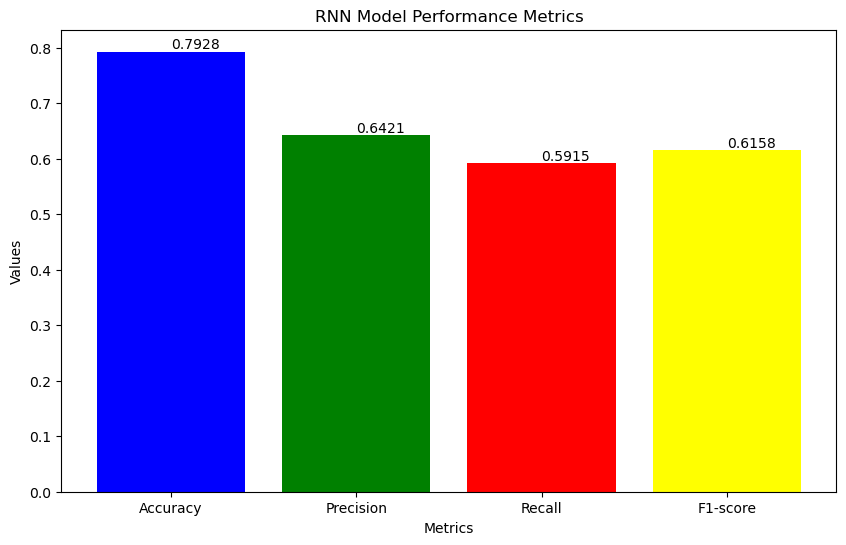

In [8]:
# 성능 평가 지표를 리스트로 정리
model = ['RNN', 'RNN', 'RNN', 'RNN']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [rnn_accuracy, rnn_precision, rnn_recall, rnn_f1]

# 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'red', 'yellow'])

# 막대 그래프에 값 표시
for bar, value in zip(bars, values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(value, 4), va='bottom')  # 중앙 정렬 및 값 표시

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('RNN Model Performance Metrics')
plt.show()

#### 1-2. LSTM Model

In [9]:
### LSTM 모델 ###
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(sequence_length, len(features))))
lstm_model.add(Dense(1, activation='sigmoid'))  # 이진 분류를 위한 sigmoid 활성화 함수
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # 이진 분류를 위한 손실 함수와 평가 지표

# 모델 학습
lstm_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# 모델 평가
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test, y_test)
lstm_predictions = (lstm_model.predict(X_test) > 0.5).astype(int)

# 평가지표
lstm_accuracy = accuracy_score(y_test, lstm_predictions)
lstm_precision = precision_score(y_test, lstm_predictions)
lstm_recall = recall_score(y_test, lstm_predictions)
lstm_f1 = f1_score(y_test, lstm_predictions)

print('LSTM Test Accuracy:', lstm_accuracy)
print('LSTM Test Precision:', lstm_precision)
print('LSTM Test Recall:', lstm_recall)
print('LSTM Test F1 Score:', lstm_f1)

Epoch 1/50


/home/hwchoi/anaconda3/envs/kdca/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8380 - loss: 0.3860 - val_accuracy: 0.7977 - val_loss: 0.4390
Epoch 2/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8593 - loss: 0.3369 - val_accuracy: 0.7965 - val_loss: 0.4301
Epoch 3/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8511 - loss: 0.3488 - val_accuracy: 0.8027 - val_loss: 0.4338
Epoch 4/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8571 - loss: 0.3356 - val_accuracy: 0.7982 - val_loss: 0.4315
Epoch 5/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8563 - loss: 0.3389 - val_accuracy: 0.8025 - val_loss: 0.4321
Epoch 6/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8596 - loss: 0.3348 - val_accuracy: 0.8050 - val_loss: 0.4366
Epoch 7/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8553 - loss: 0.3346 - val_accuracy: 0.7978 - val_loss: 0.4492
Epoch 8/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8606 - loss: 0.3262 - val_accuracy: 0.8036 - val_

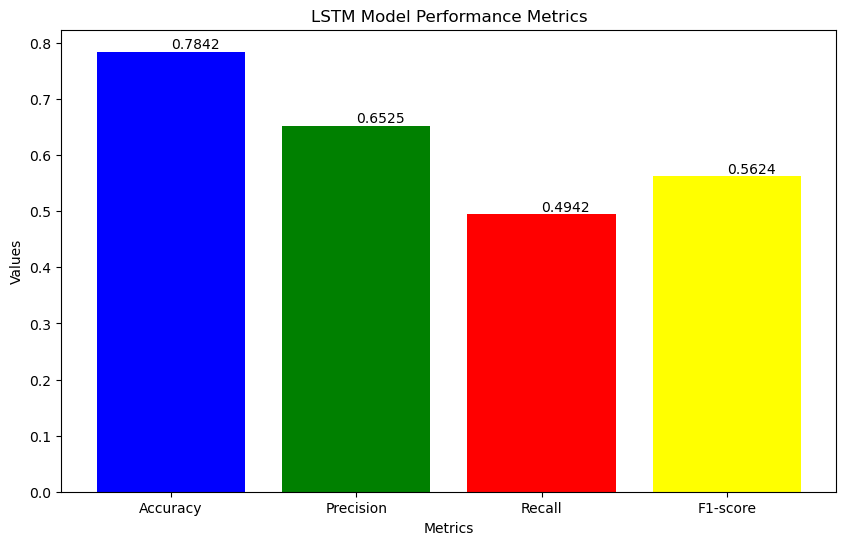

In [10]:
# 성능 평가 지표를 리스트로 정리
model = ['LSTM', 'LSTM', 'LSTM', 'LSTM']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [lstm_accuracy, lstm_precision, lstm_recall, lstm_f1]

# 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'red', 'yellow'])

# 막대 그래프에 값 표시
for bar, value in zip(bars, values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(value, 4), va='bottom')  # 중앙 정렬 및 값 표시

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('LSTM Model Performance Metrics')
plt.show()



#### 1-3. RandomForest Model

In [11]:
# randomforest, xgboost는 flatten 과정 필요
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

rf_model = RandomForestClassifier(n_estimators=100, random_state=11)
rf_model.fit(X_train_flat, y_train)

# 모델 평가
rf_predictions = rf_model.predict(X_test_flat)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)
rf_f1 = f1_score(y_test, rf_predictions)


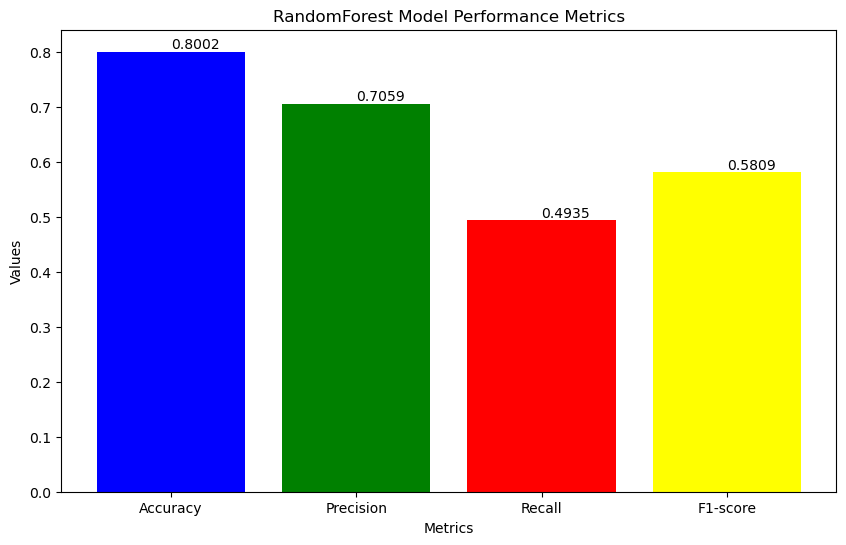

In [12]:
# 성능 평가 지표를 리스트로 정리
model = ['RandomForest', 'RandomForest', 'RandomForest', 'RandomForest']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [rf_accuracy, rf_precision, rf_recall, rf_f1]

# 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'red', 'yellow'])

# 막대 그래프에 값 표시
for bar, value in zip(bars, values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(value, 4), va='bottom')  # 중앙 정렬 및 값 표시

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('RandomForest Model Performance Metrics')
plt.show()

#### 1-4. XGBoost model

In [13]:
### XGBoost 모델 ###
xgb_model = XGBClassifier(n_estimators=100, random_state=11)
xgb_model.fit(X_train_flat, y_train)

# 모델 평가
xgb_predictions = xgb_model.predict(X_test_flat)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_precision = precision_score(y_test, xgb_predictions)
xgb_recall = recall_score(y_test, xgb_predictions)
xgb_f1 = f1_score(y_test, xgb_predictions)


# 성능 평가 지표를 리스트로 정리
model = ['XGBoost', 'XGBoost', 'XGBoost', 'XGBoost']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [xgb_accuracy, xgb_precision, xgb_recall, xgb_f1]

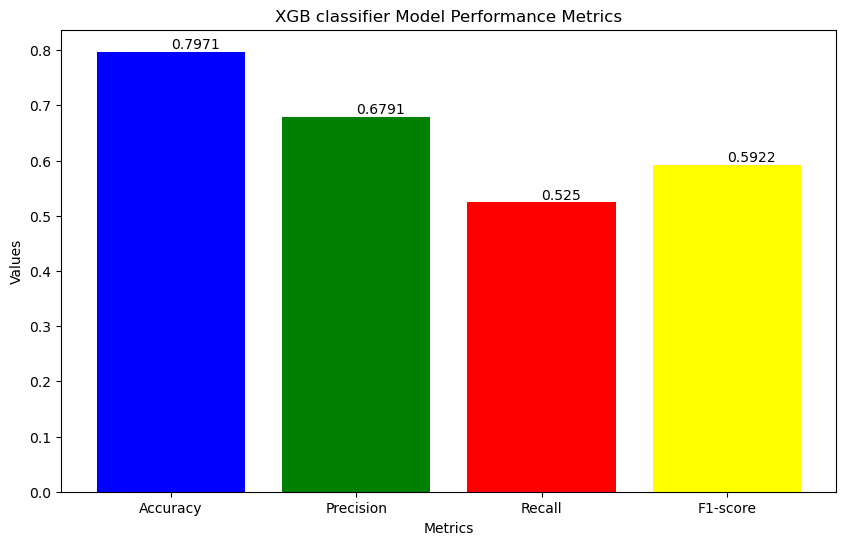

In [14]:
# 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'red', 'yellow'])

# 막대 그래프에 값 표시
for bar, value in zip(bars, values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(value, 4), va='bottom')  # 중앙 정렬 및 값 표시

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('XGB classifier Model Performance Metrics')
plt.show()

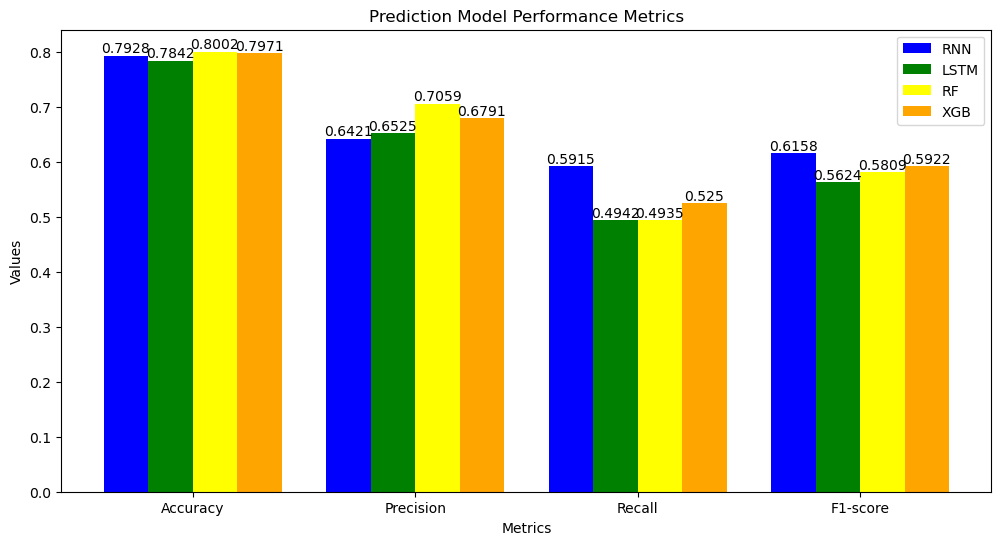

In [15]:
# 성능 평가 지표를 리스트로 정리
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
rnn_values = [rnn_accuracy, rnn_precision, rnn_recall, rnn_f1]
lstm_values = [lstm_accuracy, lstm_precision, lstm_recall, lstm_f1]
rf_values = [rf_accuracy, rf_precision, rf_recall, rf_f1]
xgb_values = [xgb_accuracy, xgb_precision, xgb_recall, xgb_f1]

# 시각화
x = np.arange(len(metrics))  # 각 지표에 대한 레이블 위치
width = 0.2  # 막대 너비

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - 1.5 * width, rnn_values, width, label='RNN', color='blue')
bars2 = ax.bar(x - 0.5 * width, lstm_values, width, label='LSTM', color='green')
bars3 = ax.bar(x + 0.5 * width, rf_values, width, label='RF', color='yellow')
bars4 = ax.bar(x + 1.5 * width, xgb_values, width, label='XGB', color='orange')

# 막대 그래프에 값 표시
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), va='bottom', ha='center')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
add_labels(bars4)

# 레이블 및 제목 설정
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Prediction Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# plt.savefig('Prediction Model Performance Metrics.png')
plt.show()

RNN Test Accuracy: 0.7928
RNN Test Precision: 0.6421
RNN Test Recall: 0.5915
RNN Test F1 Score: 0.6158
LSTM Test Accuracy: 0.7842
LSTM Test Precision: 0.6525
LSTM Test Recall: 0.4942
LSTM Test F1 Score: 0.5624
RandomForest Test Accuracy: 0.8002
RandomForest Test Precision: 0.7059
RandomForest Test Recall: 0.4935
RandomForest Test F1 Score: 0.5809
XGBoost Test Accuracy: 0.7971
XGBoost Test Precision: 0.6791
XGBoost Test Recall: 0.5250
XGBoost Test F1 Score: 0.5922


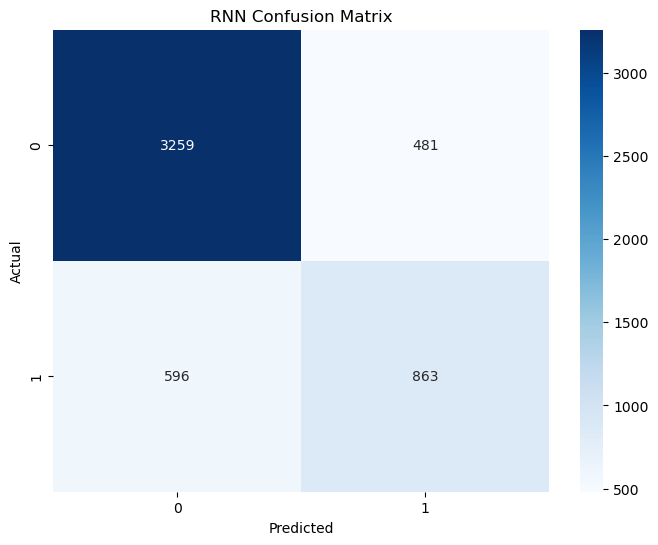

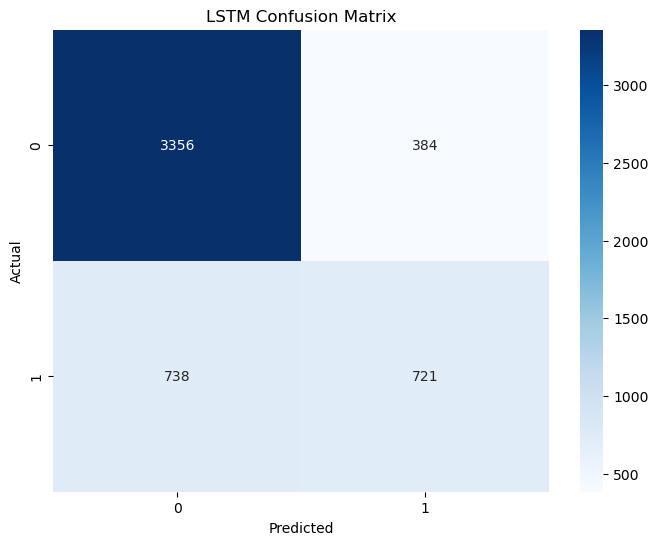

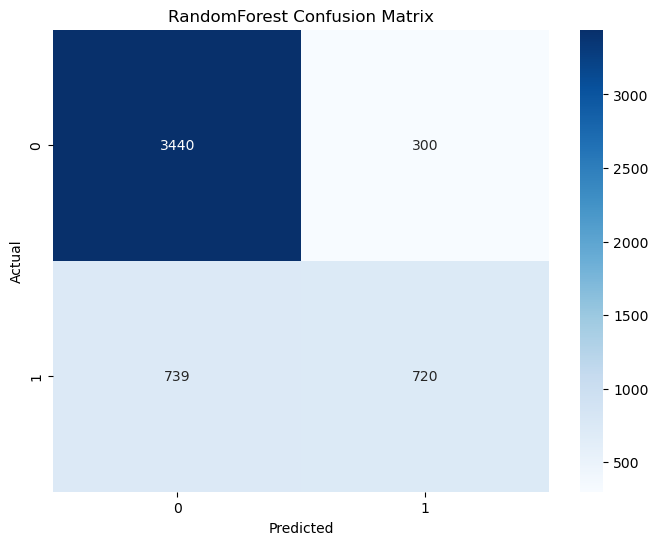

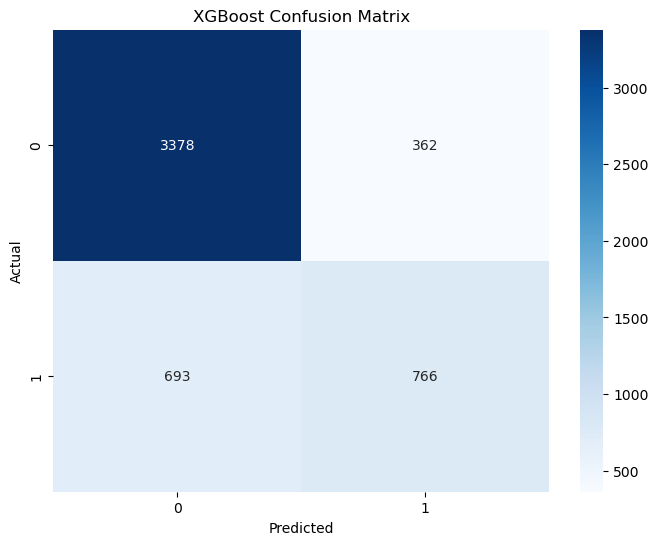

In [16]:
# 결과 출력
def print_metrics(model_name, accuracy, precision, recall, f1):
    print(f'{model_name} Test Accuracy: {accuracy:.4f}')
    print(f'{model_name} Test Precision: {precision:.4f}')
    print(f'{model_name} Test Recall: {recall:.4f}')
    print(f'{model_name} Test F1 Score: {f1:.4f}')

print_metrics('RNN', rnn_accuracy, rnn_precision, rnn_recall, rnn_f1)
print_metrics('LSTM', lstm_accuracy, lstm_precision, lstm_recall, lstm_f1)
print_metrics('RandomForest', rf_accuracy, rf_precision, rf_recall, rf_f1)
print_metrics('XGBoost', xgb_accuracy, xgb_precision, xgb_recall, xgb_f1)

# 혼동 행렬 시각화
def plot_confusion_matrix(y_test, predictions, model_name):
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(y_test, rnn_predictions, 'RNN')
plot_confusion_matrix(y_test, lstm_predictions, 'LSTM')
plot_confusion_matrix(y_test, rf_predictions, 'RandomForest')
plot_confusion_matrix(y_test, xgb_predictions, 'XGBoost')